#Import


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
import keras
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
#print(os.listdir("../input"))
from keras.layers.pooling import GlobalAveragePooling2D
# Any results you write to the current directory are saved as output.
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input, Dropout
from keras.models import Model
from tqdm import tqdm
from sklearn import preprocessing
from keras.layers import BatchNormalization
from keras import optimizers

#Focal loss
https://github.com/Tony607/Focal_Loss_Keras/blob/master/src/keras_focal_loss.ipynb

In [ ]:
from tensorflow import keras
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        print(y_true)
        print(y_pred)
        epsilon = 1.e-9
        y_true = tf.dtypes.cast(y_true, tf.float32)
        #y_true = tf.convert_to_tensor(y_true, tf.float32)
        print("y_true", y_true)
        #y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)

In [ ]:
# borrowed from https://github.com/yu4u/mixup-generator
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [ ]:
# borrowed from https://github.com/yu4u/mixup-generator
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

#Data

In [ ]:

def load_raw_images_df(data_frame,filenamecol,labelcol,img_size,n_classes,i):
    
    n_images = len(data_frame)
    X = np.empty((n_images,img_size,img_size,3))
    Y = np.zeros((n_images,n_classes))
    for index,entry in data_frame.iterrows():
        Y[index,entry[labelcol]] = 1 # one hot encoding of the label
        # Load the image and resize
        img = cv2.imread(entry[filenamecol])
        X[index,:] = cv2.resize(img, (img_size, img_size))
        X[index,:] = X[index,:] / 255.0
    return X,Y

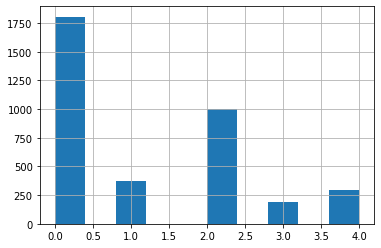

In [ ]:
train_raw_data = pd.read_csv("/content/drive/MyDrive/Nhan_Dang/Do_An/train.csv")
train_raw_data["filename"] = train_raw_data["id_code"].map(lambda x:os.path.join("/content/drive/MyDrive/Nhan_Dang/Do_An/Data/train_images",x+".png"))
train_raw_data.diagnosis.hist() # See the distribution of the classes
# train_raw_data.dtypes

# # train_data["diagnosis"] = train_data["diagnosis"].astype(str)
# # print(train_data.head())
# # print(train_data.diagnosis.unique()) # Look at different types of classes
# # labels = list(map(str,range(5)))
# # print(labels)

In [ ]:
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]

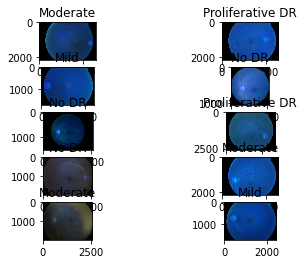

In [ ]:
# Display some images
figure, ax = plt.subplots(5,2)
ax = ax.flatten()
for i,row in train_raw_data.iloc[0:10,:].iterrows():
    ax[i].imshow(cv2.imread(os.path.join("/content/drive/MyDrive/Nhan_Dang/Do_An/Data/train_images",row["id_code"]+".png")))
    ax[i].set_title(label_title[str(row["diagnosis"])])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df,val_df = train_test_split(train_raw_data,random_state=42,shuffle=True,test_size=0.333)
#train_dff, test_df = train_test_split(train_df,random_state=42,shuffle=True,test_size=0.1)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
#test_df.reset_index(drop=True,inplace=True)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train,random_state=42,shuffle=True,test_size=0.15)

In [ ]:
X_train,Y_train = load_raw_images_df(train_df,"filename","diagnosis",img_size,5,i)
X_val,Y_val = load_raw_images_df(val_df,"filename","diagnosis",img_size,5, i=1)

In [ ]:
batch_size = 32
img_size = 224

In [ ]:
X_train=np.load('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/X_train.npy')
Y_train=np.load('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/Y_train.npy')
X_val=np.load('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/X_val.npy')
Y_val=np.load('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/Y_val.npy')
X_test=np.load('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/X_test.npy')
Y_test=np.load('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/Y_test.npy')

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

2075
1220
367


In [ ]:
import numpy as np
from PIL import Image
import os


new_dir = "Y_test"
directory = r"/content/drive/MyDrive/Nhan_Dang/Do_An/Data"
Data_dir = os.path.join(directory, new_dir)
os.makedirs(Data_dir)
print("Directory '%s' created" %Data_dir)

np.save(Data_dir, Y_test)

Directory '/content/drive/MyDrive/Nhan_Dang/Do_An/Data/Y_test' created


In [ ]:
Y_train_labels = np.argmax(Y_train,axis=1)
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train_labels),Y_train_labels)
cls_wt_dict = dict(enumerate(class_weights))
print(cls_wt_dict)

{0: 0.40397022332506205, 1: 1.9304347826086956, 2: 0.7333333333333333, 3: 3.7282442748091604, 4: 2.6688524590163936}


In [ ]:
datagen = ImageDataGenerator(            
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)
training_generator = MixupGenerator(X_train, Y_train, batch_size=32, alpha=0.2, datagen=datagen)()
valid_generator = ImageDataGenerator(rescale=1./255)
validation = MixupGenerator(X_val, Y_val, batch_size=32, alpha=0.2, datagen=datagen)()

#DenseNet121 categorical-crossentropy


In [ ]:
class QWKCallback(Callback):
    def __init__(self,val_data):
        super(Callback, self).__init__()
        self.validation_data = val_data
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/drive/MyDrive/Nhan_Dang/Do_An/Resnet50_bestqwk.h5')

In [ ]:

validation_data=(X_val, Y_val)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/DenseNet121.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]

In [ ]:
def buildModel():
    DenseNet121_model = DenseNet121(include_top=False,weights=None,input_shape=(224,224,3))
#   pretrained model https://www.kaggle.com/xhlulu/densenet-keras
    DenseNet121_model.load_weights('/content/drive/MyDrive/Nhan_Dang/Do_An/DenseNet-BC-121-32-no-top.h5')
#     model = keras.Sequential()
    
#     model.add(keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu', 
#                       input_shape = (img_size,img_size,3)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(units = 512, activation = 'relu'))
#     model.add(keras.layers.Dense(units = 5, activation = 'softmax'))
    
    p  = keras.layers.GlobalAveragePooling2D()(DenseNet121_model.output)
#     fl = keras.layers.Flatten()(p)
#     d2 = keras.layers.Dense(units = 1024, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(p)
#     d1 = keras.layers.Dense(units = 512, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(d2)
    d11 = keras.layers.Dense(units = 256, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.0001))(p)
    o1 = keras.layers.Dense(units = 5, activation = 'softmax')(d11)
    model = keras.models.Model(inputs = DenseNet121_model.input,outputs = o1)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics = ['accuracy', 'AUC'])
    print(model.summary())
    return model

In [ ]:
my_model = buildModel()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
my_model.load_weights('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/DenseNet121.h5')

In [ ]:
my_model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/5
76/76 [==============================] - 36s 472ms/step - loss: 1.0436 - accuracy: 0.7340 - auc: 0.7845 - val_loss: 0.7368 - val_accuracy: 0.7213 - val_auc: 0.9386

Epoch 00001: val_loss did not improve from 0.71608
Epoch 0 : QWK: 0.7820630291844705
Epoch 2/5
76/76 [==============================] - 36s 475ms/step - loss: 0.9936 - accuracy: 0.7336 - auc: 0.7881 - val_loss: 0.7241 - val_accuracy: 0.7139 - val_auc: 0.9367

Epoch 00002: val_loss did not improve from 0.71608
Epoch 1 : QWK: 0.7598237487006232
Epoch 3/5
76/76 [==============================] - 35s 456ms/step - loss: 0.9840 - accuracy: 0.7430 - auc: 0.7818 - val_loss: 0.6148 - val_accuracy: 0.7730 - val_auc: 0.9541

Epoch 00003: val_loss improved from 0.71608 to 0.61478, saving model to /content/drive/MyDrive/Nhan_Dang/Do_An/Data/DenseNet121.h5


In [ ]:
for layer in my_model.layers:
    layer.trainable = True

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Nhan_Dang/Do_An/Resnet50_bestqwk.h5')

In [ ]:
my_model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [QWKCallback(validation_data)],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
76/76 [==============================] - 79s 585ms/step - loss: 0.9135 - accuracy: 0.7912 - auc: 0.8114 - val_loss: 0.6245 - val_accuracy: 0.7705 - val_auc: 0.9565
Epoch 0 : QWK: 0.8711722728100103
saving checkpoint:  0.8711722728100103
Epoch 2/5
76/76 [==============================] - 36s 470ms/step - loss: 0.8494 - accuracy: 0.7794 - auc: 0.8038 - val_loss: 1.5219 - val_accuracy: 0.5205 - val_auc: 0.8332
Epoch 1 : QWK: 0.7013630693254642
Epoch 3/5
76/76 [==============================] - 34s 453ms/step - loss: 0.8570 - accuracy: 0.7697 - auc: 0.8091 - val_loss: 0.8710 - val_accuracy: 0.7131 - val_auc: 0.9276
Epoch 2 : QWK: 0.7854825758302973
Epoch 4/5
76/76 [==============================] - 35s 462ms/step - loss: 0.8541 - accuracy: 0.8045 - auc: 0.8169 - val_loss: 1.0459 - val_accuracy: 0.7090 - val_auc: 0.9092
Epoch 3 : QWK: 0.75664353

In [ ]:
y_pre1 = model.predict(X_test)

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       186
           1       0.57      0.60      0.58        35
           2       0.77      0.86      0.81       102
           3       0.83      0.59      0.69        17
           4       0.94      0.56      0.70        27

    accuracy                           0.86       367
   macro avg       0.81      0.72      0.75       367
weighted avg       0.86      0.86      0.86       367



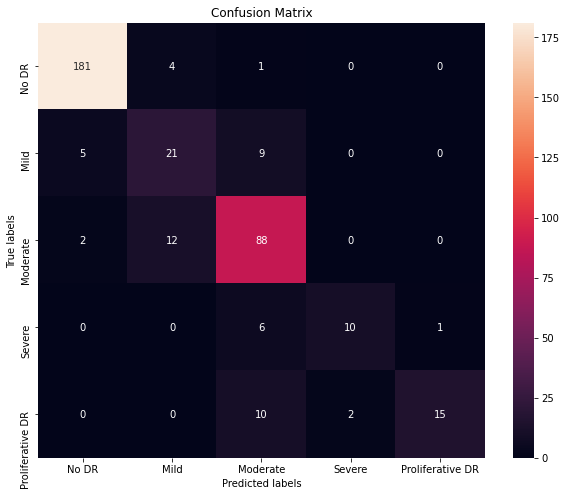

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

y_pred_classes = [np.argmax(element) for element in y_pre1]
 
print("Classification Report: \n", classification_report(y_true, y_pred_classes))

cnf_matrix = confusion_matrix(y_true, y_pred_classes)

labels = ["No DR","Mild","Moderate","Severe","Proliferative DR"]
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);



# DenseNet121 FocalLoss






In [ ]:
class QWKCallback(Callback):
    def __init__(self,val_data):
        super(Callback, self).__init__()
        self.validation_data = val_data
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/drive/MyDrive/Nhan_Dang/Do_An/DenseNet121-focal-1_bestqwk.h5')

In [ ]:
EPOCHS = 50
validation_data = (X_val, Y_val)
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/DenseNet121-focal-1.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]

In [ ]:
def buildModel_focal():
    DenseNet121_model = DenseNet121(include_top=False,weights=None,input_shape=(224,224,3))
    DenseNet121_model.load_weights('/content/drive/MyDrive/Nhan_Dang/Do_An/DenseNet-BC-121-32-no-top.h5')
#     model = keras.Sequential()
    
#     model.add(keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu', 
#                       input_shape = (img_size,img_size,3)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(units = 512, activation = 'relu'))
#     model.add(keras.layers.Dense(units = 5, activation = 'softmax'))
    
    p  = GlobalAveragePooling2D()(DenseNet121_model.output)
#     fl = keras.layers.Flatten()(p)
#     d2 = keras.layers.Dense(units = 1024, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(p)
#     d1 = keras.layers.Dense(units = 512, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(d2)
    d11 = Dense(units = 256, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.0001))(p)
    o1 = Dense(units = 5, activation = 'softmax')(d11)
    model = Model(inputs = DenseNet121_model.input,outputs = o1)
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,loss=FocalLoss(alpha=0.5), metrics = ['accuracy', 'AUC'])
    print(model.summary())
    return model

In [ ]:
my_model_focal = buildModel_focal()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
my_model_focal.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/5
76/76 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.6842 - auc: 0.7758 Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model_1/dense_3/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 2143s 28s/step - loss: 0.4659 - accuracy: 0.6842 - auc: 0.7758 - val_loss: 0.8245 - val_accuracy: 0.6041 - val_auc: 0.8528

Epoch 00001: val_loss improved from inf to 0.82450, saving model to /content/drive/MyDrive/Nhan_Dang/Do_An/Data/DenseNet121-focal-1.h5
Epoch 0 : QWK: 0.6292998992656986
saving checkpoint:  0.6292998992656986
Epoch 2/5
76/76 [==============================] - 2117s 28s/step - loss: 0.3277 - accuracy: 0.7603 - auc: 0.7971 - val_loss: 0.6660 - val_accuracy: 0.6861 - val_auc: 0.8931

Epoch 00002: val_loss improved from 0.82450 to 0.66601, saving model to /content/drive/MyDrive/Nhan_Dang/Do_An/Data/DenseNet121-focal-1.h5
Epoch 1 : Q

In [ ]:
my_model_focal = keras.models.load_model('/content/drive/MyDrive/Nhan_Dang/Do_An/DenseNet121-focal-1_bestqwk.h5')

In [ ]:
model_test.load_weights('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/DenseNet121-focal-1.h5')

In [ ]:
model_test.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.7897 - auc: 0.8035 Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 2283s 29s/step - loss: 0.2880 - accuracy: 0.7897 - auc: 0.8036 - val_loss: 0.5727 - val_accuracy: 0.7246 - val_auc: 0.9265


KeyboardInterrupt: ignored

In [ ]:
y_pre = model_test.predict(X_test)

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       186
           1       0.50      0.86      0.63        35
           2       0.74      0.74      0.74       102
           3       0.60      0.35      0.44        17
           4       0.90      0.33      0.49        27

    accuracy                           0.82       367
   macro avg       0.74      0.65      0.65       367
weighted avg       0.84      0.82      0.82       367



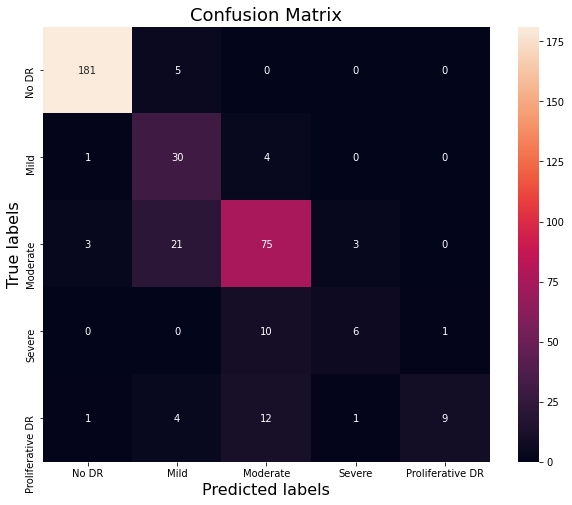

In [ ]:
y_true = [np.argmax(element) for element in Y_test]

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

y_pred_classes = [np.argmax(element) for element in y_pre]
 
print("Classification Report: \n", classification_report(y_true, y_pred_classes))

cnf_matrix = confusion_matrix(y_true, y_pred_classes)

labels = ["No DR","Mild","Moderate","Severe","Proliferative DR"]
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'16'}
ax.set_xlabel('Predicted labels', fontdict=label_font);ax.set_ylabel('True labels',fontdict=label_font); 
title_font = {'size':'18'}
ax.set_title('Confusion Matrix',fontdict=title_font); 

ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);

#DenseNet121 none pretrained model

---



In [ ]:

validation_data=(X_val, Y_val)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/DenseNet121_focal_0.5.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]

In [ ]:
def buildModel():
    DenseNet121_model = DenseNet121(include_top=False,weights=None,input_shape=(224,224,3))
    #DenseNet121_model.load_weights('/content/drive/MyDrive/Nhan_Dang/Do_An/DenseNet-BC-121-32-no-top.h5')
#     model = keras.Sequential()
    
#     model.add(keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu', 
#                       input_shape = (img_size,img_size,3)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(units = 512, activation = 'relu'))
#     model.add(keras.layers.Dense(units = 5, activation = 'softmax'))
    
    p  = GlobalAveragePooling2D()(DenseNet121_model.output)
#     fl = keras.layers.Flatten()(p)
#     d2 = keras.layers.Dense(units = 1024, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(p)
#     d1 = keras.layers.Dense(units = 512, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(d2)
    d11 = Dense(units = 256, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.0001))(p)
    o1 = Dense(units = 5, activation = 'softmax')(d11)
    model = Model(inputs = DenseNet121_model.input,outputs = o1)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,loss=FocalLoss(alpha=0.5), metrics = ['accuracy', 'AUC'])
    print(model.summary())
    return model

In [ ]:
model = buildModel()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.load_weights('/content/drive/MyDrive/Nhan_Dang/Do_An/Data/DenseNet121_focal_0.5.h5')
for layer in model.layers:
    layer.trainable = True

In [ ]:
history = model.fit(training_generator, epochs=3,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/6
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model_1/dense_3/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model_1/dense_3/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.6778 - auc: 0.7601Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model_1/dense_3/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 122s 593ms/step - loss: 0.2615 - accuracy: 0.6778 - auc: 0.7601 - val_loss: 0.4213 - val_accuracy: 0.5123 - val_auc: 0

In [ ]:
y_pre = model.predict(X_test)
y_true = [np.argmax(element) for element in Y_test]

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.65      0.74       186
           1       0.67      0.17      0.27        35
           2       0.56      0.85      0.68       102
           3       0.02      0.06      0.02        17
           4       0.00      0.00      0.00        27

    accuracy                           0.58       367
   macro avg       0.42      0.35      0.34       367
weighted avg       0.67      0.58      0.59       367



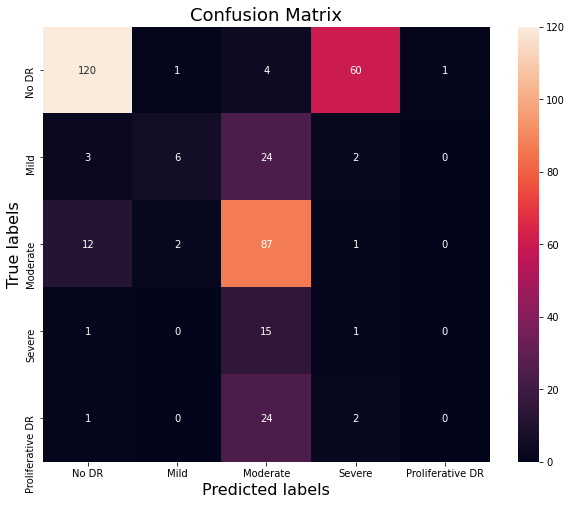

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

y_pred_classes = [np.argmax(element) for element in y_pre]
 
print("Classification Report: \n", classification_report(y_true, y_pred_classes))

cnf_matrix = confusion_matrix(y_true, y_pred_classes)

labels = ["No DR","Mild","Moderate","Severe","Proliferative DR"]
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'16'}
ax.set_xlabel('Predicted labels', fontdict=label_font);ax.set_ylabel('True labels',fontdict=label_font); 
title_font = {'size':'18'}
ax.set_title('Confusion Matrix',fontdict=title_font);

ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);